In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from scipy.optimize import minimize
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

In [2]:
# Environment
class MO_Test(gym.Env):
    def __init__(self, N=61, lam=1.0):
        super().__init__()
        self.N = N
        self.lam = lam
        vals = np.linspace(-2.0, 2.0, N, dtype=np.float32)
        grid = np.stack(np.meshgrid(vals, vals), axis=-1)
        self.points = grid.reshape(-1, 2)  
        self.action_space = spaces.Discrete(self.points.shape[0])
        self.observation_space = spaces.Box(-1.0, 1.0, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        return np.zeros(1, dtype=np.float32), {}

    def step(self, a):
        # definition of the objective functions
        x1, x2 = self.points[a]
        term = 0.5*(np.sqrt(1+(x1+x2)**2) + np.sqrt(1+(x1-x2)**2))
        f1 = term + 0.5*(x1 - x2) + self.lam*np.exp(-(x1-x2)**2)
        f2 = term - 0.5*(x1 - x2) + self.lam*np.exp(-(x1-x2)**2)
        reward = np.array([-f1, -f2], dtype=np.float32)
        done = True
        return np.zeros(1, dtype=np.float32), reward, done, False, {}

In [3]:
# Actor & Critc 
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64), nn.ReLU(),
            nn.Linear(64, act_dim)
        )
    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

In [4]:
# GAE &  direction
def collect_rollout(env, policy, batch_size, device):
    S, A, LP, R, D = [], [], [], [], []
    obs, _ = env.reset()
    for _ in range(batch_size):
        vec = np.zeros(1, dtype=np.float32)
        S.append(vec)
        state = torch.from_numpy(vec).to(device)
        logits = policy(state.unsqueeze(0))
        dist = Categorical(logits=logits)
        a = dist.sample().item()
        lp = dist.log_prob(torch.tensor(a, device=device)).item()
        _, rv, done, _, _ = env.step(a)
        A.append(a); LP.append(lp); R.append(rv); D.append(done)
        if done:
            obs, _ = env.reset()
    S_arr = np.vstack(S).astype(np.float32)
    A_arr = np.array(A, dtype=np.int64)
    LP_arr = np.array(LP, dtype=np.float32)
    R_arr = np.vstack(R).astype(np.float32)
    D_arr = np.array(D, dtype=np.float32)
    return {
        'states':      torch.from_numpy(S_arr).to(device),
        'actions':     torch.from_numpy(A_arr).to(device),
        'old_logps':   torch.from_numpy(LP_arr).to(device),
        'rewards':     torch.from_numpy(R_arr).to(device),
        'dones':       torch.from_numpy(D_arr).to(device),
        'next_states': torch.from_numpy(S_arr).to(device),
    }

def GAE(rewards, states, next_states, dones, critic, gamma, lam):
    vals = critic(states).detach().cpu().numpy()
    nvals = critic(next_states).detach().cpu().numpy()
    rews = rewards.detach().cpu().numpy()
    dns = dones.detach().cpu().numpy()
    adv = np.zeros_like(rews)
    last = 0.0
    for t in reversed(range(len(rews))):
        mask = 1 - dns[t]
        delta = rews[t] + gamma * nvals[t] * mask - vals[t]
        last = delta + gamma * lam * mask * last
        adv[t] = last
    return (torch.tensor(adv, dtype=torch.float32, device=states.device),
            torch.tensor(adv + vals, dtype=torch.float32, device=states.device))

def ppo_loss(policy, states, actions, old_logps, advs, eps):
    logits = policy(states)
    dist = Categorical(logits=logits)
    ratio = torch.exp(dist.log_prob(actions) - old_logps)
    s1 = ratio * advs
    s2 = torch.clamp(ratio, 1-eps, 1+eps) * advs
    return -torch.mean(torch.min(s1, s2))

def lambda_solver(grads):
    G = np.vstack(grads)
    def obj(l): return np.linalg.norm(l.dot(G))**2
    cons = [ {'type':'eq','fun': lambda l: l.sum()-1},
             {'type':'ineq','fun': lambda l: l} ]
    x0 = np.ones(len(grads)) / len(grads)
    return minimize(obj, x0, constraints=cons).x

# SVD direction
def direction(grads, k):
    G = np.vstack(grads) 
    _, _, Vh = np.linalg.svd(G, full_matrices=False)
    v = Vh[-1]
    return torch.tensor(v / np.linalg.norm(v), dtype=torch.float32)

In [5]:
# Pareto Tracer PPO
def pareto_tracer_ppo(env,
                    policy,
                    critics, 
                    alpha, 
                    eps, 
                    N, 
                    batch_size,
                    gamma=0.99, 
                    lam=0.95, 
                    ppo_epochs=5, 
                    log_int=50, 
                    device='cpu'):
    
    policy.to(device)
    for c in critics: c.to(device)

    optimizer = torch.optim.Adam(
        list(policy.parameters()) + [p for c in critics for p in c.parameters()], lr=3e-4)
    
    logs = {'its': [], 'objs': [[] for _ in critics], 'lams': []}
    for it in range(1, N+1):
        data = collect_rollout(env, policy, batch_size, device)

        advs, rets, grads = [], [], []

        for i, cri in enumerate(critics):
            a, r = GAE( data['rewards'][:,i],
                        data['states'], 
                        data['next_states'], 
                        data['dones'], 
                        cri, gamma, lam)
            advs.append(a); rets.append(r)

        for i in range(len(critics)):
            loss_i = ppo_loss(policy, data['states'], 
                              data['actions'], 
                              data['old_logps'], 
                              advs[i], eps)
            optimizer.zero_grad(); loss_i.backward(retain_graph=True)

            grads.append(parameters_to_vector([p.grad for p in policy.parameters()]).cpu().numpy())
        lambdas = lambda_solver(grads)
        v = direction(grads, len(critics))
        theta = parameters_to_vector(policy.parameters()); theta += alpha * v.to(theta.device)
        vector_to_parameters(theta, policy.parameters())

        for _ in range(ppo_epochs):
            loss_tot = sum(ppo_loss(policy, 
                                    data['states'], 
                                    data['actions'], 
                                    data['old_logps'], 
                                    advs[i], eps)
                                    
                           for i in range(len(critics)))
            optimizer.zero_grad(); loss_tot.backward(); optimizer.step()
        for i, cri in enumerate(critics):
            loss_val = F.mse_loss(cri(data['states']), rets[i])
            optimizer.zero_grad(); loss_val.backward(); optimizer.step()
        if it % log_int == 0:
            avg = data['rewards'].mean(dim=0).cpu().numpy().tolist()
            logs['its'].append(it)
            for i in range(len(critics)): logs['objs'][i].append(avg[i])
            logs['lams'].append(lambdas)
            print(f"Iter {it}/{N} | Returns {avg} | Lambdas {np.round(lambdas,3).tolist()}")
    return logs

Device: cpu
Iter 50/500 | Returns [-2.090947151184082, -2.144397735595703] | Lambdas [0.564, 0.436]
Iter 100/500 | Returns [-2.0176048278808594, -2.1000919342041016] | Lambdas [0.54, 0.46]
Iter 150/500 | Returns [-1.5399181842803955, -2.084709644317627] | Lambdas [0.272, 0.728]
Iter 200/500 | Returns [-0.7957301139831543, -2.291888952255249] | Lambdas [0.468, 0.532]
Iter 250/500 | Returns [-0.7775092720985413, -2.286168098449707] | Lambdas [0.283, 0.717]
Iter 300/500 | Returns [-0.7727857828140259, -2.2867181301116943] | Lambdas [0.143, 0.857]
Iter 350/500 | Returns [-0.7656692266464233, -2.285916805267334] | Lambdas [0.266, 0.734]
Iter 400/500 | Returns [-0.7604397535324097, -2.288825035095215] | Lambdas [0.5, 0.5]
Iter 450/500 | Returns [-0.7674139738082886, -2.2916977405548096] | Lambdas [0.257, 0.743]
Iter 500/500 | Returns [-0.7575500011444092, -2.292055130004883] | Lambdas [0.5, 0.5]


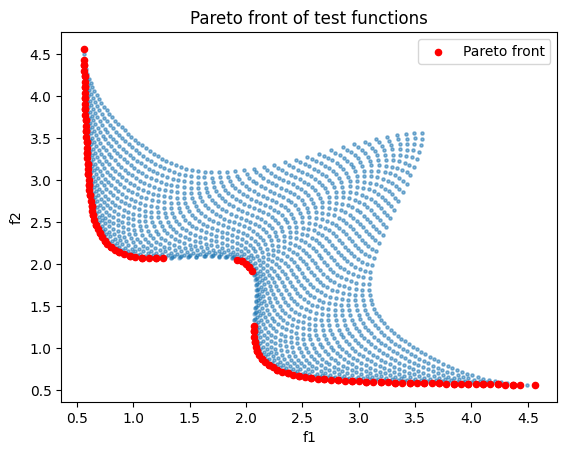

In [6]:
# main trainnig
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    env = MO_Test(N=61, lam=1.0)
    obs,_ = env.reset()
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    policy = Actor(obs_dim, act_dim)
    critics = [Critic(obs_dim) for _ in range(2)]

    logs = pareto_tracer_ppo(
        env, policy, critics,
        alpha=0.01, 
        eps=0.2, 
        N=500, 
        batch_size=1024,
        gamma=0.99, 
        lam=0.95, 
        ppo_epochs=5, 
        log_int=50,
        device=device
    )

    #  get true Pareto front
    pts = []
    for idx in range(env.action_space.n):
        _, rew, _, _, _ = env.step(idx)
        pts.append(-rew)  
    pts = np.array(pts)
    def pareto_mask(x,y):
        N = len(x); mask = np.ones(N, bool)
        for i in range(N):
            for j in range(N):
                if (x[j]<=x[i] and y[j]<=y[i]) and (x[j]<x[i] or y[j]<y[i]): mask[i]=False; break
        return mask
    mask = pareto_mask(pts[:,0], pts[:,1])

    # plot it
    plt.figure()
    plt.scatter(pts[:,0], pts[:,1], s=5, alpha=0.3)
    plt.scatter(pts[mask,0], pts[mask,1], color='red', s=20, label='Pareto front')
    plt.xlabel('f1'); plt.ylabel('f2'); plt.title('Pareto front of test functions')
    plt.legend(); plt.show()